**Introduction**

I've always wanted to build an end to end ml solution - starting with model creation and ending with a live web app. Here I've managed to do it. Users are able to submit a picture of a skin lesion and get an instant prediction. This kernel details the process I followed to build the model and then convert it from Keras to Tensorflow.js. The javascript, html and css code for the app is available on github. <br>

Web App:<br>http://skin.test.woza.work/<br>
Github: <br>https://github.com/vbookshelf/Skin-Lesion-Analyzer<br>

This model classifies skin lesions into seven classes. It is a fine tuned MobileNet CNN. All training was done in this kernel. The main challenges were the unbalanced dataset and the small amount of data.  I used data augmentation to reduce the class imbalance and in so doing get categorical accuracy scores that were not heavily skewed by a single majority class.

These were the final results:

> validation_top_3_accuracy:              0.9401197575047583<br>
> validation_top_2_accuracy:             0.8622754462316127<br>
> validation_categorical_accuracy:   0.6616766458291732<br>

MobileNet’s small size (approx. 35MB) and speed makes it ideal for web deployment. It’s also a joy to train.

Tensorflow.js is a new library that allows machine learning models to run in the browser - without having to download or install any additional software. Because the model is running locally, any data that a user submits never leaves his or her pc or mobile phone. I imagine that privacy is especially important when it comes to medical data.

<hr>

**What is the objective?**

I found it very helpful to define a clear objective right at the start. This helps guide the model selection process. For example, if a model has an accuracy of 60% it would usually be seen as a bad model. However, if it also has a top 3 accuracy of 90% and the objective requires that it output 3 predictions then it may actually be quite a good model. 

*This is the objective that I defined for this task:*

> Create an online tool that can tell doctors and lab technologists the three highest probability diagnoses for a given skin lesion. This will help them quickly identify high priority patients and speed up their workflow. The app should produce a result in less than 3 seconds. To ensure privacy the images must be pre-processed and analysed locally and never be uploaded to an external server.


In [7]:
from numpy.random import seed
seed(101)
# from tensorflow import set_random_seed
# set_random_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


**LABELS**<br>

Excerpts from the paper:<br>
> The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions<br>
https://arxiv.org/abs/1803.10417



 **nv**<br>
 Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.<br>
 *[6705 images]*
 
 **mel**<br>
 Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.<br>*[1113 images]*
 
 
**bkl**<br>
 "Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation
and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.<br>
*[1099 images]*

**bcc**<br>
Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.<br>
*[514 images]*
 
**akiec**<br>
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.<br>*[327 images]*


**vasc**<br>
Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.<br>
*[142 images]*

**df**<br>
Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].<br>*[115 images]*


<br>*[Total images = 10015]*

In [8]:
dataset_dir = '../../Documents/skin-cancer-mnist-ham10000/'

os.listdir(dataset_dir)

['HAM10000_images_part_2',
 'hmnist_28_28_RGB.csv',
 'hmnist_28_28_L.csv',
 'hmnist_8_8_L.csv',
 'ham10000_images_part_1',
 'HAM10000_images_part_1',
 'ham10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_8_8_RGB.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators. 

In [16]:
# # Create a new directory
base_dir = 'base_dir'
# # if base_dir not in os.listdir():
# #     os.mkdir(base_dir)


# #[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# # now we create 7 folders inside 'base_dir':

# # train
#     # nv
#     # mel
#     # bkl
#     # bcc
#     # akiec
#     # vasc
#     # df
# # val
#     # nv
#     # mel
#     # bkl
#     # bcc
#     # akiec
#     # vasc
#     # df

# # create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
# os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
# os.mkdir(val_dir)


# # [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# # Inside each folder we create seperate folders for each class

# # create new folders inside train_dir
# nv = os.path.join(train_dir, 'nv')
# os.mkdir(nv)
# mel = os.path.join(train_dir, 'mel')
# os.mkdir(mel)
# bkl = os.path.join(train_dir, 'bkl')
# os.mkdir(bkl)
# bcc = os.path.join(train_dir, 'bcc')
# os.mkdir(bcc)
# akiec = os.path.join(train_dir, 'akiec')
# os.mkdir(akiec)
# vasc = os.path.join(train_dir, 'vasc')
# os.mkdir(vasc)
# df = os.path.join(train_dir, 'df')
# os.mkdir(df)



# # create new folders inside val_dir
# nv = os.path.join(val_dir, 'nv')
# os.mkdir(nv)
# mel = os.path.join(val_dir, 'mel')
# os.mkdir(mel)
# bkl = os.path.join(val_dir, 'bkl')
# os.mkdir(bkl)
# bcc = os.path.join(val_dir, 'bcc')
# os.mkdir(bcc)
# akiec = os.path.join(val_dir, 'akiec')
# os.mkdir(akiec)
# vasc = os.path.join(val_dir, 'vasc')
# os.mkdir(vasc)
# df = os.path.join(val_dir, 'df')
# os.mkdir(df)

### Create Train and Val Sets

In [10]:
df_data = pd.read_csv(dataset_dir + '/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
#X = df_data.drop('dx', axis=1)
y = df_data['dx']

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(9013, 7)
(1002, 7)


In [12]:
df_train['dx'].value_counts()

nv       6034
mel      1002
bkl       989
bcc       463
akiec     294
vasc      128
df        103
Name: dx, dtype: int64

In [13]:
df_val['dx'].value_counts()

nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: dx, dtype: int64

### Transfer the Images into the Folders

In [14]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [17]:
# Get a list of images in each of the two folders
folder_1 = os.listdir(dataset_dir + '/ham10000_images_part_1')
folder_2 = os.listdir(dataset_dir + '/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(dataset_dir + '/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(dataset_dir + '/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(dataset_dir + '/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(dataset_dir + '/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [18]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

6034
1002
989
463
294
128
103


In [19]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

671
111
110
51
33
14
12


### Copy the train images  into aug_dir

In [23]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    if aug_dir not in os.listdir():
        os.mkdir(aug_dir)
        
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    if img_dir not in os.listdir():
        os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1002 images belonging to 1 classes.
Found 989 images belonging to 1 classes.
Found 463 images belonging to 1 classes.
Found 294 images belonging to 1 classes.
Found 128 images belonging to 1 classes.
Found 103 images belonging to 1 classes.


In [24]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

6034
5810
5984
5606
5930
5170
4170


In [25]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

671
111
110
51
33
14
12


### Visualize 50 augmented images

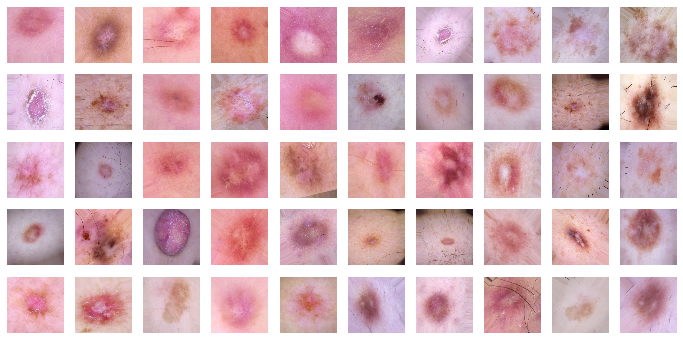

In [26]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [ ]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Set Up the Generators

In [27]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [28]:
train_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    train_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=train_batch_size)
valid_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    shuffle=False)

Found 38704 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


### Modify MobileNet Model

In [29]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 8s 0us/step


In [30]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [32]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [34]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [35]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [36]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])



In [37]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [38]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [40]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [41]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30
902/902 [==============================] - 40s 45ms/step - loss: 1.7653 - categorical_accuracy: 0.5099 - top_2_accuracy: 0.7089 - top_3_accuracy: 0.8385 - val_loss: 0.3475 - val_categorical_accuracy: 0.3423 - val_top_2_accuracy: 0.7026 - val_top_3_accuracy: 0.8303

Epoch 00001: val_top_3_accuracy improved from -inf to 0.83034, saving model to model.h5
Epoch 2/30
902/902 [==============================] - 39s 43ms/step - loss: 1.2530 - categorical_accuracy: 0.6124 - top_2_accuracy: 0.8108 - top_3_accuracy: 0.9141 - val_loss: 1.6977 - val_categorical_accuracy: 0.5259 - val_top_2_accuracy: 0.7665 - val_top_3_accuracy: 0.8972

Epoch 00002: val_top_3_accuracy improved from 0.83034 to 0.89721, saving model to model.h5
Epoch 3/30
902/902 [==============================] - 40s 45ms/step - loss: 1.1646 - categorical_accuracy: 0.6394 - top_2_accuracy: 0.8401 - top_3_accuracy: 0.9341 - val_loss: 8.0867 - val_categorical_accuracy: 0.1257 - val_top_2_accuracy: 0.3493 - val_top_3_accuracy

902/902 [==============================] - 39s 43ms/step - loss: 0.3462 - categorical_accuracy: 0.8962 - top_2_accuracy: 0.9765 - top_3_accuracy: 0.9961 - val_loss: 0.0115 - val_categorical_accuracy: 0.6158 - val_top_2_accuracy: 0.8263 - val_top_3_accuracy: 0.9301

Epoch 00023: val_top_3_accuracy did not improve from 0.94711
Epoch 24/30
902/902 [==============================] - 39s 44ms/step - loss: 0.3343 - categorical_accuracy: 0.8932 - top_2_accuracy: 0.9745 - top_3_accuracy: 0.9961 - val_loss: 1.0081 - val_categorical_accuracy: 0.6138 - val_top_2_accuracy: 0.8293 - val_top_3_accuracy: 0.9331

Epoch 00024: val_top_3_accuracy did not improve from 0.94711

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 25/30
902/902 [==============================] - 39s 44ms/step - loss: 0.3321 - categorical_accuracy: 0.8968 - top_2_accuracy: 0.9777 - top_3_accuracy: 0.9953 - val_loss: 0.5348 - val_categorical_accuracy: 0.6148 - val_top_2_accuracy: 0.8263 - va

### Evaluate the model using the val set

In [42]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [43]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 6.395290256477892e-05
val_cat_acc: 0.6057884097099304
val_top_2_acc: 0.8273453116416931
val_top_3_acc: 0.9301397204399109


In [44]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.6341476440429688
val_cat_acc: 0.742514967918396
val_top_2_acc: 0.8872255682945251
val_top_3_acc: 0.9471057653427124


In [45]:
demo_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=1,
                                                    shuffle=False)

Found 1002 images belonging to 7 classes.


In [ ]:
input_image = demo_batches
plt.imshow(input_image)

prediction = model.predict(demo_batches)

In [48]:
print(len(prediction))

NameError: name 'prediction' is not defined

### Plot the Training Curves

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [ ]:
# Get the labels of the test images.
# Note that cats and dogs are in seperate folders therefore
# the code below can get the labels depending on the folder the image is in.

test_labels = test_batches.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

In [ ]:
# Print the label associated with each class
test_batches.class_indices

In [ ]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

In [ ]:
predictions.shape

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

### Install Tensorflow.js

In [ ]:
!pip install tensorflowjs

### Convert the model
Note: Do not load a saved model and try to convert it. It will not work.

In [ ]:
# create a directory to store the model files
os.mkdir('tfjs_dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_dir')

In [ ]:
# check the the directory containing the model is available
!ls

In [ ]:
# view the files that make up the tensorflow.js model
os.listdir('tfjs_dir')

In [ ]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('base_dir')

### Resources

These are some resources that I used:

1. Excellent tutorial series by deeplizard on how to use Mobilenet with Tensorflow.js<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

2. Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

3. Tutorial by Data School on how to evaluate a classifier<br>
https://www.youtube.com/watch?v=85dtiMz9tSo

3. Tensorflow.js gallery of projects<br>
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md



### Conclusion

Many thanks to Kevin Mader (@kmader) for posting this dataset. Thanks Kaggle for the free GPU.

Thank you for reading. 